---
layout: exercises
chapter: 2
permalink: /ml-book/chapter2/exercises.html
---

## Exercise 1

Try a Support Vector Machine with various hyperparameters. So that means grid search on the hyperparameters. We're going to start from scratch just to recall all the steps.

In [1]:
import tarfile
import tempfile
import urllib.request
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing_url = (
    "https://raw.githubusercontent.com/ageron/"
    + "handson-ml/master/datasets/housing/housing.tgz"
)
FIGSIZE = (16, 12)


def read_tar(url):
    r = urllib.request.urlopen(url)
    with tempfile.TemporaryDirectory() as d:
        with tarfile.open(fileobj=r, mode="r:gz") as tf:
            tf.extractall(path=d)
            name = tf.getnames()[0]
        df = pd.read_csv(os.path.join(d, name))
    return df


df = read_tar(housing_url)

# Stratify by important features
strat_values = df["median_income"]
bins = 5
strat = np.ceil(strat_values / 1.5)
strat = strat.where(strat < 5, 5.0)
df["income_cat"] = strat
strat_train_set, strat_test_set = train_test_split(
    df, test_size=0.2, random_state=42, stratify=strat
)

# Remove strat feature
cols = [i for i in df.columns if i != "income_cat"]
df = df.loc[:, cols]
strat_train_set = strat_train_set.loc[:, cols]
strat_test_set = strat_test_set.loc[:, cols]

# Add combo features
df["population_per_household"] = df["population"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["rooms_per_household"] = df["total_rooms"] / df["households"]

# Remove target from inputs
target = "median_house_value"
x = df[[col for col in df.columns if col != target]].copy()
y = df[[target]].copy()

In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Pipeline
cat_cols = ["ocean_proximity"]
num_cols = [col for col in x.columns if col not in cat_cols]

num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ]
)

pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_cols),
        ("cat", OneHotEncoder(), cat_cols),
    ]
)
x_final = pipeline.fit_transform(x)
y_final = y.copy().values[:, 0]
print(x_final.shape)
print(y_final.shape)

(20640, 16)
(20640,)


In [11]:
# Grid search
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR

param_grid = [
    {"kernel": ["linear"], "C": np.logspace(-2, 2, 5)},
    {"kernel": ["rbf"], "C": np.logspace(-2, 2, 5), "gamma": np.logspace(-3, 1, 5)},
]

svr_reg = SVR()

grid_search = GridSearchCV(
    svr_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=4,
    verbose=4,
)
grid_search.fit(x_final, y_final)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 15.1min finished


GridSearchCV(cv=5, estimator=SVR(), n_jobs=4,
             param_grid=[{'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['linear']},
                         {'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=4)

In [12]:
print(grid_search.best_params_)
# Since these were the max we probably want to run it with higher values...
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'C': 100.0, 'kernel': 'linear'}
SVR(C=100.0, kernel='linear')
120046.83746066342 {'C': 0.01, 'kernel': 'linear'}
119313.36974987865 {'C': 0.1, 'kernel': 'linear'}
112692.04970886311 {'C': 1.0, 'kernel': 'linear'}
84708.66839222891 {'C': 10.0, 'kernel': 'linear'}
74449.9743277484 {'C': 100.0, 'kernel': 'linear'}
120132.95001003973 {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
120131.66921718646 {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
120129.58678535324 {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
120132.74223046939 {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
120133.11221026107 {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
120131.32982041281 {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
120118.43736317645 {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
120097.61802146187 {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
120129.26313275466 {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
120133.07528895183 {'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}
120115.04323111309 {'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}


In [13]:
# Best one is: 74449.9743277484 {'C': 100.0, 'kernel': 'linear'}

## Exercise 2
Try `RandomizedSearchCV` instead of the grid search.

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import recipinvgauss, reciprocal

# Since C is centered at

param_grid = {
    "kernel": ["linear", "rbf"],
    "C": reciprocal(1, 1000000),
    "gamma": recipinvgauss(mu=1, scale=0.5),
}


svr_reg = SVR()

grid_search = RandomizedSearchCV(
    svr_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=4,
    n_iter=30,
    verbose=4,
)
grid_search.fit(x_final, y_final)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 11.8min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 19.4min finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=30, n_jobs=4,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x132d145e0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13225eaf0>,
                                        'kernel': ['linear', 'rbf']},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=4)

0.40364256834993917
1.322189693395722
28.2468988692541
31881.1740923203


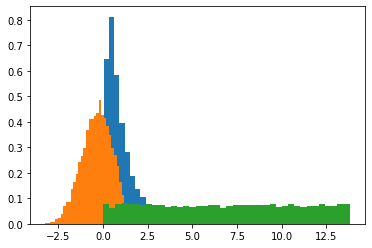

In [49]:
%matplotlib inline
from scipy.stats import recipinvgauss, reciprocal
import matplotlib.pyplot as plt

rv = recipinvgauss(mu=1, scale=0.5)
vals = rv.rvs(size=10000)
plt.hist(vals, bins=40, density=True)
plt.hist(np.log(vals), bins=40, density=True)
print(np.quantile(vals, 0.25))
print(np.quantile(vals, 0.75))

rv1 = reciprocal(1, 1000000)
vals = rv1.rvs(size=10000)
# plt.hist(vals, bins=40, density=True)
plt.hist(np.log(vals), bins=40, density=True)
print(np.quantile(vals, 0.25))
print(np.quantile(vals, 0.75))

In [50]:
print(grid_search.best_params_)
# Since these were the max we probably want to run it with higher values...
print(grid_search.best_estimator_)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'C': 213086.81055914456, 'gamma': 0.43753758012999744, 'kernel': 'rbf'}
SVR(C=213086.81055914456, gamma=0.43753758012999744)
86922.13248255629 {'C': 8.366566042717265, 'gamma': 0.570389688549627, 'kernel': 'linear'}
108940.09733634934 {'C': 112.90281928704358, 'gamma': 0.34622625583652333, 'kernel': 'rbf'}
77482.89380061901 {'C': 69496.08270814756, 'gamma': 1.4269585049166456, 'kernel': 'linear'}
88694.80156763176 {'C': 7.3920771548663655, 'gamma': 3.094038787353801, 'kernel': 'linear'}
77478.50967107895 {'C': 29100.862636014495, 'gamma': 0.34570001769982, 'kernel': 'linear'}
77480.15495365753 {'C': 166038.1616977072, 'gamma': 0.716976295083469, 'kernel': 'linear'}
77173.14674835099 {'C': 7754.122689703942, 'gamma': 0.6299597811263543, 'kernel': 'linear'}
67179.25553893886 {'C': 213086.81055914456, 'gamma': 0.43753758012999744, 'kernel': 'rbf'}
75000.92839623214 {'C': 431.7411750880907, 'gamma': 1.4726229965871818, 'kernel': 'linear'}
77776.81326184724 {'C': 23.73956017569095, 'gamma'

In [51]:
# Best was 67179.25553893886 {'C': 213086.81055914456, 'gamma': 0.43753758012999744, 'kernel': 'rbf'}
# Better than before, but it probably make more sense to learn
# about hyperparameters and how they work, than just guessing randomly

## Exercise 3
Add a transformer in the pipeline to select only the most important attributes.

In [111]:
from sklearn.base import BaseEstimator, TransformerMixin

feature_importances = [
    (0.3317845401920315, "median_income"),
    (0.14391320344674868, "INLAND"),
    (0.10526089823364354, "population_per_household"),
    (0.08263855622539133, "bedrooms_per_room"),
    (0.08109436950269967, "longitude"),
    (0.06119936528237925, "latitude"),
    (0.05437513667126127, "rooms_per_household"),
    (0.04269180191935387, "housing_median_age"),
    (0.018543650605563098, "population"),
    (0.017855965561009164, "total_rooms"),
    (0.01747459825864214, "total_bedrooms"),
    (0.016371631697584668, "households"),
    (0.015137593949840484, "<1H OCEAN"),
    (0.006837130390816489, "NEAR OCEAN"),
    (0.004801246718794319, "NEAR BAY"),
    (2.0311344240502856e-05, "ISLAND"),
]

encoder_classes = ["<1H OCEAN", "INLAND", "ISLAND", "NEAR BAY", "NEAR OCEAN"]


class ImportantFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, cols, features=8):
        self.feature_importances = feature_importances
        self.cols = cols
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cs = [i[1] for i in self.feature_importances[: self.features]]
        # Sort here to maintain order
        idxs = sorted([self.cols.index(i) for i in cs])
        return X[:, idxs]


# Pipeline
cat_cols = ["ocean_proximity"]
num_cols = [col for col in x.columns if col not in cat_cols]

num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("std_scaler", StandardScaler()),
    ]
)

pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

pipeline = Pipeline(
    [
        ("full_pipeline", pipeline),
        (
            "important_selector",
            ImportantFeatureSelector(
                feature_importances, num_cols + encoder_classes, features=8
            ),
        ),
    ]
)
x_final = pipeline.fit_transform(x)
y_final = y.copy().values[:, 0]
# I double checked that this worked, but commenting out the Standard Scaler
# and comparing to first row of x and x_final

## Exercise 4
Try creating a single pipeline that does the full data preparation plus the final prediction.

In [112]:
ex4_pipeline = Pipeline(
    [
        ("prev_pipeline", pipeline),
        ("svr", SVR(**grid_search.best_params_)),
    ]
)
# This runs .transform on prev_pipeline(?), seems like it did
ex4_model = ex4_pipeline.fit(x, y_final)

In [113]:
ex4_data = x.iloc[:4]
ex4_labels = y_final[:4]
print(ex4_model.predict(ex4_data).round())
print(ex4_labels)

[448803. 424097. 436690. 313041.]
[452600. 358500. 352100. 341300.]


## Exercise 5
Automatically explore some preparation options using `GridSearchCV`.

In [114]:
print("\n".join(list(ex4_pipeline.get_params().keys())))

memory
steps
verbose
prev_pipeline
svr
prev_pipeline__memory
prev_pipeline__steps
prev_pipeline__verbose
prev_pipeline__full_pipeline
prev_pipeline__important_selector
prev_pipeline__full_pipeline__n_jobs
prev_pipeline__full_pipeline__remainder
prev_pipeline__full_pipeline__sparse_threshold
prev_pipeline__full_pipeline__transformer_weights
prev_pipeline__full_pipeline__transformers
prev_pipeline__full_pipeline__verbose
prev_pipeline__full_pipeline__num
prev_pipeline__full_pipeline__cat
prev_pipeline__full_pipeline__num__memory
prev_pipeline__full_pipeline__num__steps
prev_pipeline__full_pipeline__num__verbose
prev_pipeline__full_pipeline__num__imputer
prev_pipeline__full_pipeline__num__std_scaler
prev_pipeline__full_pipeline__num__imputer__add_indicator
prev_pipeline__full_pipeline__num__imputer__copy
prev_pipeline__full_pipeline__num__imputer__fill_value
prev_pipeline__full_pipeline__num__imputer__missing_values
prev_pipeline__full_pipeline__num__imputer__strategy
prev_pipeline__full_

In [115]:
grid_params = [
    {
        "prev_pipeline__full_pipeline__num__imputer__strategy": [
            "mean",
            "most_frequent",
        ],
        "prev_pipeline__important_selector__features": list(range(3, 6)),
        "svr__epsilon": np.logspace(-2, 0, 3),
    }
]

gs = GridSearchCV(
    ex4_pipeline,
    grid_params,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=4,
    verbose=4,
)
gs.fit(x, y_final)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  6.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prev_pipeline',
                                        Pipeline(steps=[('full_pipeline',
                                                         ColumnTransformer(transformers=[('num',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('std_scaler',
                                                                                                           StandardScaler())]),
                                                                                          ['longitude',
                                                                                           'latitude',
                                     

In [116]:
print(gs.best_params_)
# Since these were the max we probably want to run it with higher values...
print(gs.best_estimator_)
cvres = gs.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'prev_pipeline__full_pipeline__num__imputer__strategy': 'most_frequent', 'prev_pipeline__important_selector__features': 4, 'svr__epsilon': 0.01}
Pipeline(steps=[('prev_pipeline',
                 Pipeline(steps=[('full_pipeline',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('std_scaler',
                                                                                    StandardScaler())]),
                                                                   ['longitude',
                                                                    'latitude',
                                                                    'housing_median_age',
                    

* It's super convenient that you can set parameters like that (i.e. using the string version)
* Exercises took too long... SVR takes a long time to fit with cv